In [2]:
%load_ext autoreload
%autoreload 2
import sys
import os
import numpy as np

sys.path.append(os.path.abspath('../../Cochlear_Implant_Hackathon/'))

from software.fitness_functions.delta_wav import compute_wavfile_delta,wavefile_MSE,wavefile_correlation,wavefile_max_xcor
# Import the rest of the GpyT subpackage functions for the demo here
from software.gp_refactor import classes
from software.gp_refactor.fitness_functions import convert_sample_rate,wavefile_max_xcor,fft_MSE
sys.modules['classes'] = classes
from software.gp_refactor.toolboxes import all_primitives

from software.AB_imports.Demo.proceduralDemo import demo4_procedural
from scipy.fftpack import fft,rfft,irfft,ifft
from sklearn.preprocessing import StandardScaler
import pyaudio as pa
from scipy.signal import resample
from scipy.io.wavfile import read as wavread
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
try:
    plt.style.use('rossidata')
except:
    pass
from glob import glob
import networkx as nx
import pickle
# from networkx.drawing.nx_agraph import graphviz_layoutimport 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# you need to import all the values
toolbox=all_primitives('../sample_data/bladerunner_replicant_test.wav',optimization='minimum')

we are currently minimizing


In [4]:
input_file_path=os.path.abspath('../sample_data/bladerunner_replicant_test.wav')

base_algo_results  = demo4_procedural(input_file_path)

/Users/nicholas.rossi/Documents/Personal/Cochlear_Implant_Hackathon/software/AB_imports/Validation/validateOutput.py:81: UserWarning: No Validation file found! Validation process will be skipped, results may not be accepted for final entry submission!!
  warnings.warn('No Validation file found! Validation process will be skipped, results may not be accepted for final entry submission!!')


In [6]:


## taking a look at checkpoints and loading one of them
most_recent=glob('../software/gp_refactor/checkpoints/*.pkl')[1]
print(most_recent)
results=pickle.load( open(most_recent, "rb" ) )

../software/gp_refactor/checkpoints/9_checkpoint.pkl


# Playback

In [7]:

p = pa.PyAudio()
devInfo = p.get_default_output_device_info()
devIndex = devInfo['index']
nChan = 1


stream = p.open(format=pa.paFloat32,
channels=nChan,
rate=results['result_scores']['frequency_input'],
output=True,
output_device_index = devIndex
)

data=results['result_scores']['audio_input']/(2**15-1)
#data=results['audi']/(2**10-1)
inData = data.astype(np.float32).tobytes()

stream.write(inData)
stream.close()



stream = p.open(format=pa.paFloat32,
channels=nChan,
rate=results['result_scores']['frequency_out'],
output=True,
output_device_index = devIndex
)

data=results['result_scores']['audio_out']#/(2**15-1)
#data=results['audi']/(2**10-1)
outdata = data.astype(np.float32).tobytes()



stream.write(outdata)
stream.close()

# Visualization

# Comparing El Grams

Text(0.5, 1.0, 'DEEP VIBE')

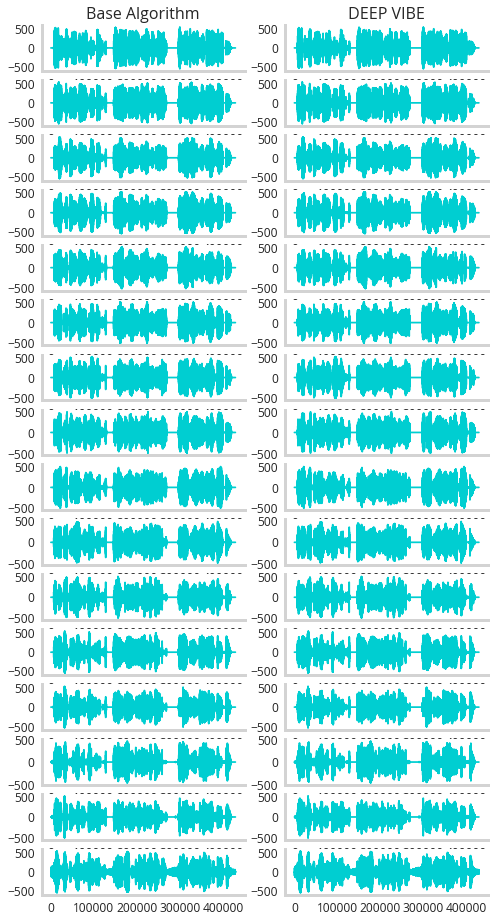

In [8]:
fig,ax=plt.subplots(16,2,figsize=(8,16))

for x in range(base_algo_results['elGram'].shape[0]):
    vect=base_algo_results['elGram'][x,:]

    ax[x,0].plot(vect)
    
    vect2=results['result_scores']['elgram'][x,:]
    ax[x,1].plot(vect)

    
ax[0,0].set_title('Base Algorithm')
ax[0,1].set_title('DEEP VIBE')

# Comparing Final Waveforms

Text(0.5, 1.0, 'DEEP VIBE')

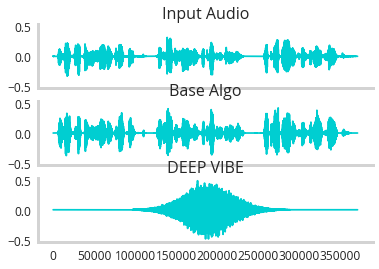

In [9]:
fig,(ax1,ax2,ax3)=plt.subplots(3,1,sharex=True,sharey=True)
resampled_input=convert_sample_rate(results['result_scores']['audio_input'],
                    results['result_scores']['frequency_input'],
                    results['result_scores']['frequency_out'])

ax1.plot(resampled_input/(2**15-1))
ax1.set_title('Input Audio')

ax2.plot(base_algo_results['audioOut'])
ax2.set_title('Base Algo')
ax3.plot(results['result_scores']['audio_out'])
ax3.set_title('DEEP VIBE')


# Scoring

In [10]:
base_algo_score=wavefile_max_xcor(results['result_scores']['audio_input'],
                                  results['result_scores']['frequency_input'],
                                  base_algo_results['audioOut'],
                                 base_algo_results['audioFs'])

deepvibe_score=wavefile_max_xcor(results['result_scores']['audio_input'],
                                  results['result_scores']['frequency_input'],
                                  results['result_scores']['audio_out'],
                                 results['result_scores']['frequency_out'])

Text(0, 0.5, 'Maximum Cross Correlation')

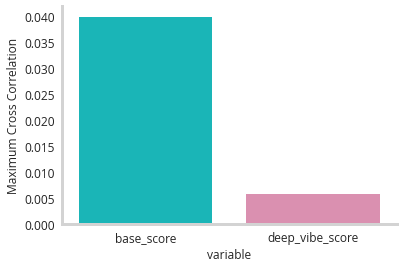

In [11]:
fig,ax=plt.subplots()
sns.barplot(x='variable',y='value',data=pd.DataFrame({'base_score':base_algo_score,
'deep_vibe_score':deepvibe_score},index=[0]).melt(),ax=ax)
ax.set_ylabel('Maximum Cross Correlation')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'DEEP VIBE')

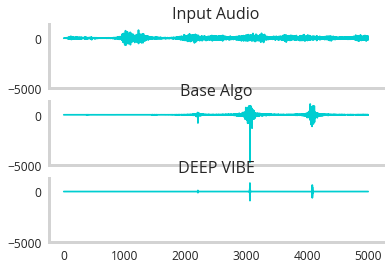

In [12]:

fig,(ax1,ax2,ax3)=plt.subplots(3,1,sharex=True,sharey=True)
resampled_input=convert_sample_rate(results['result_scores']['audio_input'],
                    results['result_scores']['frequency_input'],
                    results['result_scores']['frequency_out'])


input_fft=np.fft.rfft(resampled_input/(2**15-1))[:5000]
ax1.plot(input_fft)
ax1.set_title('Input Audio')
base_fft=np.fft.rfft(base_algo_results['audioOut'])[:5000]

ax2.plot(base_fft)
ax2.set_title('Base Algo')
deep_fft=np.fft.rfft(results['result_scores']['audio_out'])[:5000]
ax3.plot(deep_fft)
ax3.set_title('DEEP VIBE')

In [14]:
base_algo_score_fft=fft_MSE(results['result_scores']['audio_input'],
                                  results['result_scores']['frequency_input'],
                                  base_algo_results['audioOut'],
                                 base_algo_results['audioFs'])

deepvibe_score_fft=fft_MSE(results['result_scores']['audio_input'],
                                  results['result_scores']['frequency_input'],
                                  results['result_scores']['audio_out'],
                                 results['result_scores']['frequency_out'])

Text(0, 0.5, 'FFT MSE (lower better)')

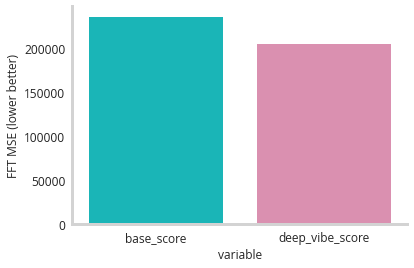

In [15]:
fig,ax=plt.subplots()
sns.barplot(x='variable',y='value',data=pd.DataFrame({'base_score':base_algo_score_fft,
'deep_vibe_score':deepvibe_score_fft},index=[0]).melt(),ax=ax)
ax.set_ylabel('FFT MSE (lower better)')

In [163]:
np.sum(abs(input_fft-base_fft))

712634.433051083

In [170]:
np.around(712634.433051083,-5)*10


7000000.0

In [171]:
base_algo_score_fft

[autoreload of software.gp_refactor.toolboxes failed: Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 434, in superreload
    module = reload(module)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/Users/nicholas.rossi/Documents/Personal/Coc

236615.5044358089